In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
import numpy as np 
from scipy.stats import sem
from gptchem.data import get_polymer_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

from gptchem.plotsettings import *

import matplotx

%matplotlib inline

In [47]:
all_res = glob("out/**/*.pkl")

In [48]:
res = load_pickle(all_res[0])

In [49]:
temperatures = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [50]:
compiled_res = []

for filename in all_res: 
    loaded = load_pickle(filename)
    try:
        for i, res in enumerate(loaded['res']):
            result = {
                'num_train_points': loaded['num_train_points'],
                'noise_level': loaded['noise_level'],
                'valid_fraction': res['valid_smiles_fraction'],
                'unique_fraction': res['unique_smiles_fraction'],
                'temp': temperatures[i],
                "fraction_in_train": res['fraction_in_train'],
                'kldiv_score': res['kldiv_score'],
                'mae': np.mean(res['losses']),
                **res['string_distances_collection_summary']
            }
            for k,v in res['summary_composition_mismatches'].items():
                result[f'comp_mismatch_{k}'] = v
        
            compiled_res.append(result)
    except Exception as e :
        print(e)
        pass
        

In [51]:
df = pd.DataFrame(compiled_res)

In [52]:
grouped = df.groupby(['num_train_points', 'temp']).agg(['mean', 'std', sem, "count"])

In [53]:
grouped

noise_level               valid_fraction                \
                             mean std sem count           mean std sem count   
num_train_points temp                                                          
100              0.00        0.01 NaN NaN     1           0.36 NaN NaN     1   
                 0.10        0.01 NaN NaN     1           0.66 NaN NaN     1   
                 0.20        0.01 NaN NaN     1           0.87 NaN NaN     1   
                 0.50        0.01 NaN NaN     1           0.99 NaN NaN     1   
                 0.75        0.01 NaN NaN     1           1.00 NaN NaN     1   
                 1.00        0.01 NaN NaN     1           0.92 NaN NaN     1   
                 1.25        0.01 NaN NaN     1           0.72 NaN NaN     1   
                 1.50        0.01 NaN NaN     1           0.33 NaN NaN     1   

                      unique_fraction      ... comp_mismatch_mean        \
                                 mean std  ...                sem count   
num_train_points temp                      ...                            
100              0.00            0.75 NaN  ...                NaN     1   
                 0.10            1.00 NaN  ...                NaN     1   
                 0.20            1.00 NaN  ...                NaN     1   
                 0.50            1.00 NaN  ...                NaN     1   
                 0.75            1.00 NaN  ...                NaN     1   
                 1.00            1.00 NaN  ...                NaN     1   
                 1.25            1.00 NaN  ...                NaN     1   
                 1.50            1.00 NaN  ...                NaN     1   

                      comp_mismatch_expected_len                \
                                            mean std sem count   
num_train_points temp                                            
100              0.00                        0.0 NaN NaN     1   
                 0.10                        0.0 NaN NaN     1   
                 0.20                        0.0 NaN NaN     1   
                 0.50                        0.0 NaN NaN     1   
                 0.75                        0.0 NaN NaN     1   
                 1.00                        0.0 NaN NaN     1   
                 1.25                        0.0 NaN NaN     1   
                 1.50                        0.0 NaN NaN     1   

                      comp_mismatch_found_len                
                                         mean std sem count  
num_train_points temp                                        
100              0.00                     0.0 NaN NaN     1  
                 0.10                     0.0 NaN NaN     1  
                 0.20                     0.0 NaN NaN     1  
                 0.50                     0.0 NaN NaN     1  
                 0.75                     0.0 NaN NaN     1  
                 1.00                     0.0 NaN NaN     1  
                 1.25                     0.0 NaN NaN     1  
                 1.50                     0.0 NaN NaN     1  

[8 rows x 92 columns]

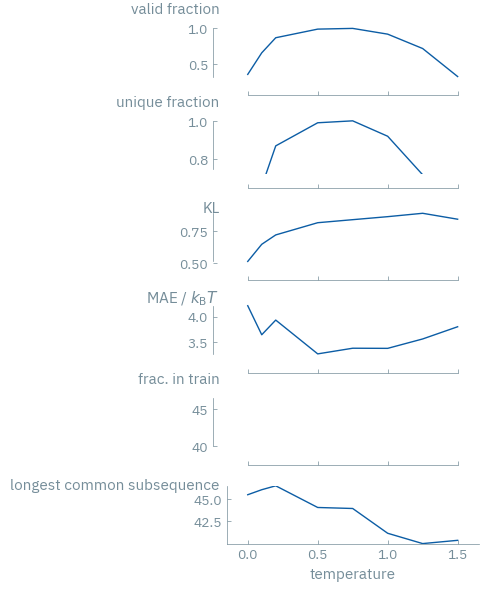

In [68]:

fig, ax = plt.subplots(6,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))

ax[0].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[0].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['valid_fraction']['mean'] -  grouped.loc[100, :]['valid_fraction']['sem'], 
    grouped.loc[100, :]['valid_fraction']['mean'] +  grouped.loc[100, :]['valid_fraction']['sem'], alpha=.5 )
ylabel_top('valid fraction', ax=ax[0])

range_frame(
    ax[0],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['valid_fraction']['mean'] ,
        grouped.loc[100, :]['valid_fraction']['mean']
    ]).flatten(),grouped.loc[100, :]['valid_fraction']['mean'].mean())
)

ax[1].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[1].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['unique_fraction']['mean'] -  grouped.loc[100, :]['unique_fraction']['sem'], 
    grouped.loc[100, :]['unique_fraction']['mean'] +  grouped.loc[100, :]['unique_fraction']['sem'], alpha=.5 )
ylabel_top('unique fraction', ax=ax[1])


range_frame(
    ax[1],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['unique_fraction']['mean'] ,
        grouped.loc[100, :]['unique_fraction']['mean']
    ]).flatten(),grouped.loc[100, :]['unique_fraction']['mean'].mean())
)


ax[2].plot(grouped.loc[100, :].index, grouped.loc[100, :]['kldiv_score']['mean'])
ax[2].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['kldiv_score']['mean'] -  grouped.loc[100, :]['kldiv_score']['sem'], 
    grouped.loc[100, :]['kldiv_score']['mean'] +  grouped.loc[100, :]['kldiv_score']['sem'], alpha=.5 )
ylabel_top('KL', ax=ax[2])


range_frame(
    ax[2],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['kldiv_score']['mean'] ,
        grouped.loc[100, :]['kldiv_score']['mean']
    ]).flatten(),grouped.loc[100, :]['kldiv_score']['mean'].mean())
)


ax[3].plot(grouped.loc[100, :].index, grouped.loc[100, :]['mae']['mean'])
ax[3].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['mae']['mean'] -  grouped.loc[100, :]['mae']['sem'], 
    grouped.loc[100, :]['mae']['mean'] +  grouped.loc[100, :]['mae']['sem'], alpha=.5 )
ylabel_top('MAE / $k_\mathrm{B}T$', ax=ax[3])

range_frame(
    ax[3],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['mae']['mean'] ,
        grouped.loc[100, :]['mae']['mean']
    ]).flatten(),grouped.loc[100, :]['mae']['mean'].mean())
)



ax[4].plot(grouped.loc[100, :].index, grouped.loc[100, :]['fraction_in_train']['mean'])
ax[4].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['fraction_in_train']['mean'] -  grouped.loc[100, :]['fraction_in_train']['sem'], 
    grouped.loc[100, :]['fraction_in_train']['mean'] +  grouped.loc[100, :]['fraction_in_train']['sem'], alpha=.5 )
ylabel_top('frac. in train', ax=ax[4])


range_frame(
    ax[4],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['fraction_in_train']['mean'] ,
        grouped.loc[100, :]['fraction_in_train']['mean']
    ]).flatten(),grouped.loc[100, :]['fraction_in_train']['mean'].mean())
)


ax[5].plot(grouped.loc[100, :].index, grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'])
ax[5].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] -  grouped.loc[100, :]['LongestCommonSubsequence_mean']['sem'], 
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] +  grouped.loc[100, :]['LongestCommonSubsequence_mean']['sem'], alpha=.5 )
ylabel_top('longest common subsequence', ax=ax[5])


range_frame(
    ax[4],
    grouped.loc[100, :].index,
np.nan_to_num(np.stack([
        grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] ,
        grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean']
    ]).flatten(),grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'].mean())
)


ax[-1].set_xlabel('temperature', labelpad=4)
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)
fig.savefig('random_polymer_inverse.pdf', bbox_inches='tight')

In [63]:
np.abs(get_polymer_data()['deltaGmin'].mean() - get_polymer_data()['deltaGmin']).mean()

2.7135963497608304